In [353]:
# Top Trumps card game (Quartett)
# Data generated with claude 3.5
data_file = "data/car-top-trumps.csv"

In [354]:
#%pip install pandas
#%pip install matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [355]:
df0 = pd.read_csv(data_file, index_col=0, parse_dates=False)
df0.dropna(axis=0, how='all', inplace=True)
df0.dropna(axis=1, how='any', inplace=True)

In [356]:
df0.head()

Horsepower  TopSpeed_MPH  Acceleration_0_60_Sec  \
Name                                                                       
Porsche 911 GT3 RS              518           198                    3.2   
Ferrari F8 Tributo              710           211                    2.9   
Lamborghini Huracan Evo         631           202                    2.9   
McLaren 720S                    710           212                    2.9   
Audi R8 V10                     562           201                    3.2   

                         Year  Price_USD  
Name                                      
Porsche 911 GT3 RS       2023     223500  
Ferrari F8 Tributo       2022     276550  
Lamborghini Huracan Evo  2023     261274  
McLaren 720S             2022     301500  
Audi R8 V10              2023     158600

In [357]:
df0.shape

(112, 5)

In [358]:
df_returns = pd.DataFrame()

# Normalize each column from df0 except the name column to be between 0 and 1
df_returns = df0.copy()
for column in df_returns.columns:
  print(column)
  print(df_returns[column].min())
  print(df_returns[column].max())
  if column != 'Name':
    df_returns[column] = (df_returns[column] - df_returns[column].min()) / (df_returns[column].max() - df_returns[column].min())

Horsepower
248
1914
TopSpeed_MPH
106
300
Acceleration_0_60_Sec
1.85
5.7
Year
1990
2023
Price_USD
32500
3100000


In [359]:
df_returns.head()

Horsepower  TopSpeed_MPH  Acceleration_0_60_Sec  \
Name                                                                       
Porsche 911 GT3 RS         0.162065      0.474227               0.350649   
Ferrari F8 Tributo         0.277311      0.541237               0.272727   
Lamborghini Huracan Evo    0.229892      0.494845               0.272727   
McLaren 720S               0.277311      0.546392               0.272727   
Audi R8 V10                0.188475      0.489691               0.350649   

                             Year  Price_USD  
Name                                          
Porsche 911 GT3 RS       1.000000   0.062266  
Ferrari F8 Tributo       0.969697   0.079560  
Lamborghini Huracan Evo  1.000000   0.074580  
McLaren 720S             0.969697   0.087694  
Audi R8 V10              1.000000   0.041108

In [360]:
# split into train and test
Ntest = 40
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

In [361]:
from enum import Enum
import pandas as pd

# Horsepower
# TopSpeed_MPH
# Acceleration_0_60_Sec
# Year
# Price_USD


class Player:
  def __init__(self, name, env):
    self.name = name
    self.env = env
    self.cards = pd.DataFrame()

  def isDone(self):
    # when we have no more cards left, we are done
    return self.cards.empty

  def insertCards(self, cards):
    # Insert cards at the end
    self.cards = pd.concat([self.cards, cards], ignore_index=True)

  def getValue(self, column):
    # return the value of the top card
    print(f"value: {self.cards.iloc[0, column]}")
    return self.cards.iloc[0, column]
  
  def removeCard(self):
    # Remove the top card and return it as a DataFrame
    top_card = self.cards.iloc[[0]]
    self.cards = self.cards.iloc[1:].reset_index(drop=True)
    return top_card
  


class Env:
  def __init__(self, card_deck):
    self.player_count = 2
    self.card_deck = card_deck.copy()
    ActionSpaceEnum = Enum('ActionSpace', {column: idx for idx, column in enumerate(df_returns.columns) if column != 'Name'}) # All columns except the name column
    self.action_space = list(ActionSpaceEnum)
    
    self.players = [Player(f"Player {i}", self) for i in range(self.player_count)]
    # the computer is always player 0
    self.agent_player = self.players[0]
    self.opponent_player = self.players[1]
    self.states = self.agent_player.cards
    self.draw_pile = pd.DataFrame()
    

  def reset(self):
    # delete the cards from the players
    for player in self.players:
      player.cards = pd.DataFrame()
    self.draw_pile = pd.DataFrame()
    # shuffle the cards and distribute them to the players
    shuffled = self.card_deck.sample(frac=1)
    for i, player in enumerate(self.players):
      player.insertCards(shuffled.iloc[i::self.player_count])
      print(f"Player {i} has {shuffled.iloc[i::self.player_count].shape[0]} cards. Total cards: {shuffled.shape[0]}")
      print(player.cards)
    return self.agent_player.cards


  def step(self, action):
    # need to return (next_state, reward, done)
    # move forward in the game
    if self.agent_player.isDone():
      print("Agent won!")
      raise Exception("Episode already done")
    
    if self.agent_player.cards.shape[0] == self.card_deck.shape[0]:
      print("Agent lost!")
      raise Exception("Episode already done")
    
    print(f"Agent plays {action}")
    print(f"Agent has {self.agent_player.cards.shape[0]} cards")
    print(f"Opponent has {self.opponent_player.cards.shape[0]} cards")
    print(f"Draw pile has {self.draw_pile.shape[0]} cards")
    print(f"Card deck has {self.card_deck.shape[0]} cards")
  

    # check who won
    # if the agent has a higher value than the opponent, he wins
    # if the agent has a lower value than the opponent, he looses
    # if the agent has the same value as the opponent, it is a draw
    isWinner = False
    agentCardValue = self.agent_player.getValue(action)
    if (self.agent_player.getValue(action) > self.opponent_player.getValue(action)):
      # agent wins
      self.agent_player.insertCards(self.opponent_player.removeCard()) # we add the card of the opponent
      self.agent_player.insertCards(self.draw_pile) # we also add the draw pile
      self.draw_pile = pd.DataFrame() # we empty the draw pile
      self.agent_player.insertCards(self.agent_player.removeCard()) # we also add the card we played
      isWinner = True
    elif (self.agent_player.getValue(action) < self.opponent_player.getValue(action)):
      # agent looses
      self.opponent_player.insertCards(self.agent_player.removeCard()) # we add the card of the agent
      self.opponent_player.insertCards(self.draw_pile) # we also add the draw pile
      self.draw_pile = pd.DataFrame() # we empty the draw pile
      self.opponent_player.insertCards(self.opponent_player.removeCard()) # we also add the card the opponent played
    else:
      # draw, we add it do a special pile
      self.draw_pile = pd.concat([self.draw_pile, self.agent_player.removeCard()])
      self.draw_pile = pd.concat([self.draw_pile, self.opponent_player.removeCard()])

    # compute reward and return state
    if isWinner:
      return self.agent_player.cards, 5 * agentCardValue, self.agent_player.isDone() or self.opponent_player.isDone()
    if self.draw_pile.shape[0] > 0: # draw
      return self.agent_player.cards, 2 * agentCardValue, self.agent_player.isDone() or self.opponent_player.isDone()
    else:
      return self.agent_player.cards, 0, self.agent_player.isDone() or self.opponent_player.isDone()

In [362]:
class Agent:
  def __init__(self, action_size):
    self.action_size = action_size
    # mehrere modelle
    # Trajektorien - ExpReplayBuffer
    ### je nach Technologie

  def act(self, state): # observes the state and decides
    return np.random.choice(self.action_size)  # take random action... better would be to take the action with the hightst probability for the top trump card game... but that is cheating

  def train(self, state, action, reward, next_state, done):
    pass

In [363]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  print("Total reward:", total_reward)
  return total_reward

In [364]:
num_episodes = 10

In [365]:
# Ensure train_data is divisible by the number of players
player_count = 2
if len(train_data) % player_count != 0:
    train_data = train_data.iloc[:-(len(train_data) % player_count)]

if len(test_data) % player_count != 0:
    test_data = test_data.iloc[:-(len(test_data) % player_count)]

train_env = Env(train_data)
test_env = Env(test_data)

In [366]:
train_env.reset()
train_env.step(1)
train_env.reset()


Player 0 has 36 cards. Total cards: 72
    Horsepower  TopSpeed_MPH  Acceleration_0_60_Sec      Year  Price_USD
0     0.154262      0.360825               0.454545  1.000000   0.016919
1     0.811525      1.000000               0.168831  0.969697   0.967400
2     0.237695      0.319588               0.584416  1.000000   0.041239
3     0.103842      0.319588               0.532468  1.000000   0.007971
4     0.121248      0.288660               0.324675  1.000000   0.007006
5     0.253902      0.510309               0.298701  1.000000   0.066830
6     0.223890      0.494845               0.272727  1.000000   0.058517
7     0.280312      0.448454               0.376623  1.000000   0.119267
8     0.034814      0.252577               1.000000  1.000000   0.003097
9     0.241297      0.525773               0.428571  1.000000   0.079022
10    0.154262      0.360825               0.506494  1.000000   0.015104
11    0.211285      0.463918               0.246753  0.969697   0.058106
12    0.1962

Horsepower  TopSpeed_MPH  Acceleration_0_60_Sec      Year  Price_USD
0     0.252101      0.484536               0.402597  1.000000   0.017112
1     0.738896      0.798969               0.142857  0.969697   0.967400
2     0.451381      0.000000               0.298701  1.000000   0.024841
3     0.080432      0.252577               0.506494  1.000000   0.003599
4     0.031813      0.304124               0.870130  1.000000   0.004042
5     0.277311      0.541237               0.272727  0.969697   0.079560
6     0.223890      0.494845               0.272727  1.000000   0.058517
7     0.306723      0.572165               0.246753  0.969697   0.158197
8     0.024010      0.252577               0.610390  0.969697   0.013822
9     0.229892      0.494845               0.272727  1.000000   0.074580
10    0.336134      0.319588               0.116883  1.000000   0.017113
11    0.040216      0.252577               0.740260  1.000000   0.003778
12    0.121248      0.288660               0.324675  1.000000   0.007006
13    0.091236      0.252577               0.688312  1.000000   0.008378
14    0.253301      0.458763               0.194805  1.000000   0.024090
15    0.221489      0.432990               0.298701  1.000000   0.031785
16    0.117647      0.350515               0.558442  0.969697   0.008606
17    0.070228      0.314433               0.688312  1.000000   0.003291
18    0.342737      0.510309               0.272727  1.000000   0.094698
19    0.153061      0.381443               0.532468  1.000000   0.014588
20    0.227491      0.432990               0.272727  0.969697   0.036021
21    0.547419      0.742268               0.168831  0.969697   0.967400
22    0.139256      0.123711               0.428571  1.000000   0.009615
23    0.103842      0.319588               0.532468  1.000000   0.007971
24    0.096038      0.108247               0.688312  1.000000   0.005183
25    0.199280      0.500000               0.558442  1.000000   0.026923
26    0.188475      0.489691               0.350649  1.000000   0.041108
27    0.196279      0.360825               0.636364  1.000000   0.029014
28    0.241297      0.474227               0.428571  1.000000   0.010660
29    0.237695      0.319588               0.584416  1.000000   0.041239
30    0.037215      0.252577               0.714286  0.939394   0.001547
31    0.241297      0.525773               0.428571  1.000000   0.079022
32    0.031212      0.288660               1.000000  0.969697   0.004368
33    0.197479      0.221649               0.688312  1.000000   0.040407
34    0.811525      1.000000               0.168831  0.969697   0.967400
35    0.091236      0.381443               0.636364  1.000000   0.020016

In [367]:
action_size = len(train_env.action_space)
agent = Agent(action_size)

In [368]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [369]:
for e in range(num_episodes):
  r = play_one_episode(agent, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tr = play_one_episode(agent, test_env, is_train=False)
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.5f}, test: {tr:.5f}")

Player 0 has 36 cards. Total cards: 72
    Horsepower  TopSpeed_MPH  Acceleration_0_60_Sec      Year  Price_USD
0     0.229892      0.412371               0.324675  1.000000   0.048346
1     0.197479      0.221649               0.688312  1.000000   0.040407
2     0.031813      0.304124               0.870130  1.000000   0.004042
3     0.280312      0.448454               0.376623  1.000000   0.119267
4     0.103842      0.319588               0.532468  1.000000   0.007971
5     0.121248      0.288660               0.324675  1.000000   0.007006
6     0.199280      0.500000               0.558442  1.000000   0.026923
7     0.154262      0.360825               0.506494  1.000000   0.015104
8     0.134454      0.319588               0.610390  1.000000   0.010913
9     0.352341      0.097938               0.298701  1.000000   0.013203
10    0.223289      0.463918               0.272727  1.000000   0.048020
11    0.031212      0.288660               1.000000  0.969697   0.004368
12    0.3073

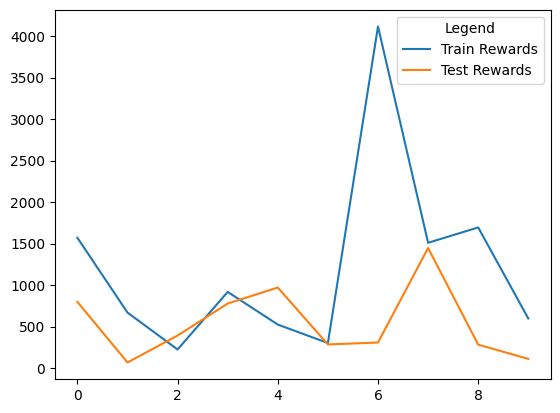

In [371]:
plt.plot(train_rewards, label='Train Rewards')
plt.plot(test_rewards, label='Test Rewards')
# Add a legend
plt.legend(title='Legend')
plt.show()